<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [20]:
import random
import io
import pickle
from urllib import request
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding
from tensorflow.keras.optimizers import Adam

### Datos
Utilizaremos como dataset los 3 volúmenes del libro "*General Anatomy applied to physiology and medicine*" de Xavier Bichat, los cuáles se obtienen en la página de [Project Gutenberg](https://www.gutenberg.org/ebooks/search/?query=GENERAL+ANATOMY+APPLIED+TO+PHYSIOLOGY+AND+MEDICINE&submit_search=Go%21).

In [2]:
# Leo el libro del archivo txt
with open('book.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Separo el texto en oraciones, las cuales se separan mediante un punto ('.')
sentences = text.split('.')

# Creo un dataframe que contiene las oraciones
df = pd.DataFrame({'Oracion': sentences})

df.head()

,Oracion
0,", VOL 1 ***\n\n\n\n\n\n\n\n\n\nProduced by Son..."
1,pgdp
2,net (This\n\nfile was produced from images gen...
3,"X\n\n\n\n_Published by Richardson & Lord, Boston"
4,_]\n\n\n\n\n\n\n\n\n\n ...


In [3]:
# Analizo 10 oraciones
df['Oracion'][4500:4510]

4500    \n\nThe cerebral which accompany them, furnish...
4501     There is merely juxta position as we see it i...
4502    \n\n\n\nI cannot repeat it too much, that the ...
4503                           \n\n\n\n\n\nARTICLE FOURTH
4504    \n\n\n\nPROPERTIES OF THE VASCULAR SYSTEM WITH...
4505    \n\n\n\nWhat we have to say of these propertie...
4506     In fact the\n\nfleshy parietes of the heart a...
4507     As to those of the common membrane they are n...
4508    \n\n\n\nI shall consider the properties of the...
4509                                        \n\n\n\n\n\nI
Name: Oracion, dtype: object

Se puede observar que las oraciones presentan muchos caractéres, números y símbolos que deben ser preprocesados.

In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 19184


### 1 - Preprocesamiento
- Primero, se preprocesa el texto.
- Luego, se transforman las oraciones en tokens.
- Además, hay que ajustarlas las oraciones al tamaño fijo de nuestra sentencia de entrada al modelo.
- Finalmente, se separan las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [5]:
# Preprocesamiento: filtro números, espacios en blanco consecutivos y caractéres especiales
book = [re.sub(r'[^a-zA-z.!?/\"\'\s]', ' ', sentence) for sentence in df['Oracion']]
book = [re.sub(r'\s+', ' ', sentence) for sentence in book]
book = [re.sub(r'[\_\[\]]', '',sentence) for sentence in book]
book = [sentence.lower() for sentence in book]

# Analizo las mismas 10 oraciones
book[4500:4510]

[' the cerebral which accompany them furnish hardly any filaments to the arteries',
 ' there is merely juxta position as we see it in the extremities in the intercostal spaces c',
 ' i cannot repeat it too much that the constant relation of the arteries with the nervous system of the ganglions deserves the attention of physiologists because it is too general not to belong to some great object of the functions of the economy though the object may be unknown',
 ' article fourth',
 ' properties of the vascular system with red blood',
 ' what we have to say of these properties will refer particularly to the arteries as well as what we have said of the organization',
 ' in fact the fleshy parietes of the heart and the membranous ones of the pulmonary veins possess properties that will be examined hereafter and which differ from those of the arteries on account of the difference of texture',
 ' as to those of the common membrane they are nearly the same in the whole course of the red blood t

**1.1 Tokenización**

Transformo las oraciones en secuencias (tokens) de palabras

In [6]:
# Entran oraciones y salen vectores de N posiciones (tokens)
sentence_tokens = [text_to_word_sequence(sentence) for sentence in book]
# Analizo como tokeniza la oración: "the cerebral which accompany them furnish hardly any filaments to the arteries"
sentence_tokens[4500]

['the',
 'cerebral',
 'which',
 'accompany',
 'them',
 'furnish',
 'hardly',
 'any',
 'filaments',
 'to',
 'the',
 'arteries']

Se crean secuencias con un largo de 4, de los cuales 3 tokens son la secuencia input al modelo y 1 corresponde a la palabra de salida a predecir

In [7]:
# Largo de la secuencia: incluye seq input + word output
train_len = 4

# Desfasaje de palabras según el train_len
text_sequences = []

for sentence in sentence_tokens:
    if len(sentence) >= train_len:
        for i in range(train_len, len(sentence) + 1):
            seq = sentence[i - train_len : i]
            text_sequences.append(seq)

print(f'Cantidad de secuencias: {len(text_sequences)}')

Cantidad de secuencias: 362229


In [8]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[4500:4510]

[['of', 'the', 'vital', 'forces'],
 ['the', 'vital', 'forces', 'to'],
 ['vital', 'forces', 'to', 'the'],
 ['forces', 'to', 'the', 'natural'],
 ['to', 'the', 'natural', 'type'],
 ['the', 'natural', 'type', 'from'],
 ['natural', 'type', 'from', 'which'],
 ['type', 'from', 'which', 'they'],
 ['from', 'which', 'they', 'have'],
 ['which', 'they', 'have', 'been']]

**1.2 Word2Vec**

A continuación, se crean los vectores de palabras para entrenar a la red.
- El input seran integers (word2vec)
- El output será one-hot encoded (labels) del tamaño del vocabulario

In [9]:
tok = Tokenizer() # el tokenizer "aprende" las palabras que se usarán
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
sequences = np.array(tok.texts_to_sequences(text_sequences))
print(f'Ejemplo de 10 secuencias:\n {sequences[4500:4510]}\n')

# Cantidad de veces que aparece cada palabra
print(f'Tamaño del vocabulario: {len(tok.word_counts)}\n')
# Cantidad de casos (doc) de entrada
print(f'Cantidad de documentos de entrada:{tok.document_count}')

Ejemplo de 10 secuencias:
 [[   2    1  141  231]
 [   1  141  231    5]
 [ 141  231    5    1]
 [ 231    5    1  195]
 [   5    1  195 1680]
 [   1  195 1680   15]
 [ 195 1680   15    9]
 [1680   15    9   19]
 [  15    9   19   17]
 [   9   19   17   71]]

Tamaño del vocabulario: 7830

Cantidad de documentos de entrada:362229


In [10]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'of',
 3: 'in',
 4: 'is',
 5: 'to',
 6: 'and',
 7: 'that',
 8: 'it',
 9: 'which',
 10: 'a',
 11: 'are',
 12: 'this',
 13: 'as',
 14: 'by',
 15: 'from',
 16: 'not',
 17: 'have',
 18: 'with',
 19: 'they',
 20: 'we',
 21: 'these',
 22: 'be',
 23: 'upon',
 24: 'their',
 25: 'its',
 26: 'an',
 27: 'at',
 28: 'but',
 29: 'or',
 30: 'blood',
 31: 'them',
 32: 'more',
 33: 'all',
 34: 'i',
 35: 'system',
 36: 'texture',
 37: 'has',
 38: 'there',
 39: 'other',
 40: 'for',
 41: 'very',
 42: 'on',
 43: 'those',
 44: 'when',
 45: 'same',
 46: 'than',
 47: 'different',
 48: 'only',
 49: 'one',
 50: 'then',
 51: 'so',
 52: 'organs',
 53: 'much',
 54: 'two',
 55: 'first',
 56: 'general',
 57: 'into',
 58: 'great',
 59: 'less',
 60: 'muscles',
 61: 'if',
 62: 'part',
 63: 'cellular',
 64: 'no',
 65: 'animal',
 66: 'each',
 67: 'place',
 68: 'many',
 69: 'can',
 70: 'mucous',
 71: 'been',
 72: 'organic',
 73: 'between',
 74: 'also',
 75: 'would',
 76: 'see',
 77: 'nerves',
 78: 'action',

In [11]:
total_words = len(tok.index_word)+1

### 2 - Input y target

Separamos las secuencias: 
  - Entrada: los primeros 3 valores de la secuencia.
  - Salida: último valor de la secuencia.

In [12]:
X = sequences[:, :-1] # todos los rows, menos la ultima col
y = sequences[:, -1] # última col de cada row

for i in range(4500,4511):
    print(f'SECUENCIA {i} = Input:{X[i]}, Target:{[y[i]]}')
    
print(f'\nTamaño de entrada: {X.shape}')
print(f'Tamaño de salida: {y.shape}')

SECUENCIA 4500 = Input:[  2   1 141], Target:[231]
SECUENCIA 4501 = Input:[  1 141 231], Target:[5]
SECUENCIA 4502 = Input:[141 231   5], Target:[1]
SECUENCIA 4503 = Input:[231   5   1], Target:[195]
SECUENCIA 4504 = Input:[  5   1 195], Target:[1680]
SECUENCIA 4505 = Input:[   1  195 1680], Target:[15]
SECUENCIA 4506 = Input:[ 195 1680   15], Target:[9]
SECUENCIA 4507 = Input:[1680   15    9], Target:[19]
SECUENCIA 4508 = Input:[15  9 19], Target:[17]
SECUENCIA 4509 = Input:[ 9 19 17], Target:[71]
SECUENCIA 4510 = Input:[19 17 71], Target:[1491]

Tamaño de entrada: (362229, 3)
Tamaño de salida: (362229,)


**2.1 One Hot Encoding**

Transformo los datos de salida con One-hot Encoding. 

In [13]:
y = to_categorical(y-1, num_classes = total_words)
y.shape

(362229, 7831)

### 3 - Entrenamiento del modelo

In [19]:
# Largo de la secuencia de entrada
input_seq_len = X.shape[1] 
# Largo del vector de salida 
output_size = total_words

In [24]:
# Defino el modelo
model = Sequential()

model.add(Embedding(input_dim = total_words, 
                    output_dim = 5, 
                    input_length = input_seq_len))

model.add(Bidirectional(LSTM(150)))
model.add(Dense(output_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 5)              39155     
                                                                 
 bidirectional_2 (Bidirectio  (None, 300)              187200    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 7831)              2357131   
                                                                 
Total params: 2,583,486
Trainable params: 2,583,486
Non-trainable params: 0
_________________________________________________________________


Puesto que se tienen muchos parámetros a entrenar y muchos datos por procesar, se decide hacer un entrenamiento solamente durante 10 épocas.

In [25]:
hist = model.fit(X, y, epochs = 10, validation_split = 0.2)

Epoch 1/10
9056/9056 [==============================] - 198s 21ms/step - loss: 5.0920 - accuracy: 0.1977 - val_loss: 4.9973 - val_accuracy: 0.2162
Epoch 2/10
9056/9056 [==============================] - 193s 21ms/step - loss: 4.5711 - accuracy: 0.2314 - val_loss: 4.9501 - val_accuracy: 0.2280
Epoch 3/10
9056/9056 [==============================] - 201s 22ms/step - loss: 4.3573 - accuracy: 0.2417 - val_loss: 4.9703 - val_accuracy: 0.2299
Epoch 4/10
9056/9056 [==============================] - 211s 23ms/step - loss: 4.2078 - accuracy: 0.2478 - val_loss: 4.9991 - val_accuracy: 0.2336
Epoch 5/10
9056/9056 [==============================] - 209s 23ms/step - loss: 4.0927 - accuracy: 0.2532 - val_loss: 5.0747 - val_accuracy: 0.2348
Epoch 6/10
9056/9056 [==============================] - 194s 21ms/step - loss: 4.0060 - accuracy: 0.2564 - val_loss: 5.1385 - val_accuracy: 0.2304
Epoch 7/10
9056/9056 [==============================] - 191s 21ms/step - loss: 3.9321 - accuracy: 0.2602 - val_loss: 5

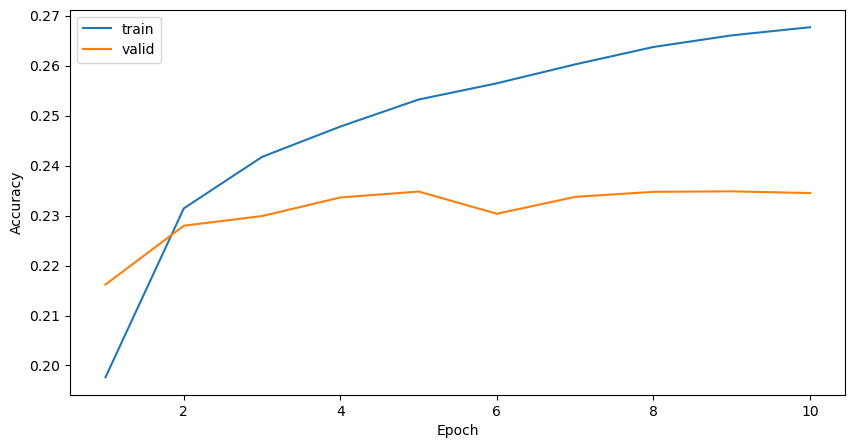

In [26]:
# Plot de accuracy en funcion de las epochs
epoch_count = range(1, len(hist.history['accuracy']) + 1)
plt.figure(figsize=(10, 5))
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### 4 - Predicción de próxima palabra

In [27]:
def model_response(human_text):
    # Encoding
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    # Predicción softmax
    y_hat = model.predict(encoded, verbose=0).argmax(axis=-1)
    # Debemos buscar en el vocabulario la palabra que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

In [28]:
model_response("you have to repeat it")

'you have to repeat it of'

In [31]:
model_response("first, breathe it")

'first, breathe it in'

In [35]:
model_response("we have red")

'we have red or'

In [36]:
model_response("when the auricles and ventricles")

'when the auricles and ventricles of'

In [37]:
model_response("It is to this")

'It is to this and'

In [41]:
model_response("the fleshy parietes")

'the fleshy parietes in'

In [98]:
model_response("have a mucous")

'have a mucous synovial'

A excepción de 'have a mucous synovial', la próxima palabra predicha podría llegar a ser correcta/tener sentido.

### 5 - Generación de secuencias nuevas

In [44]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [100]:
input_text="which they have"

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 29ms/step


'which they have mucous to these sometimes'

In [108]:
input_text="repeat it now"

generate_seq(model, tok, input_text, max_length=3, n_words=8)

1/1 [==============================] - 0s 24ms/step


'repeat it now that the see the accumulate the pellicle to'

### 6 - Conclusiones
El modelo entrenado mostró un rendimiento deficiente durante el entrenamiento, evidenciando problemas de sobreajuste. Además, se puede observar que los resultados no tienen muchos sentido. 

Se realizaron varios intentos para abordar este problema. En primer lugar, se redujo el valor de `train_len` para trabajar con secuencias de entrada de solo 2 palabras, con la esperanza de mejorar el desempeño del modelo. Sin embargo, esta modificación no produjo una mejora significativa en los resultados.

Posteriormente, se llevaron a cabo pruebas adicionales que incluyeron la combinación de múltiples capas Bidirectional LSTM, así como la combinación de capas LSTM, densas y dropout. Además, se incrementó el número de épocas de entrenamiento hasta alcanzar 100. Lamentablemente, ninguna de estas combinaciones logró obtener una precisión superior al 0.2.

Considerando que se están utilizando embeddings personalizados para el entrenamiento, se concluye que, para lograr mejoras sustanciales en las métricas y resultados, se requeriría utilizar un corpus de datos considerablemente más amplio. Esto permitiría al modelo aprender patrones y características más representativas y, potencialmente, mejorar su capacidad predictiva.